# Traffic Flow Regression
This notebook uses supervised learning to create a machine learning model that can predict the traffic flow at a junction given a set of inputs

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, validation_curve
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from mlxtend.evaluate import bias_variance_decomp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR


# Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns



# Read in Data


In [3]:
df = pd.read_csv('../../transformed_datasets/base_dataset.csv', parse_dates=True, index_col=None)

## Choose Site
We will just focus on Site N03121A because it is isolated making it less likely for multicollinearity to occur (where features depend on each other)

In [4]:
df = df[df['site']=='N03121A']
df

,scn,region,locn,X,Y,site,day,date,start_time,end_time,...,rhum,msl,month,previous_flow_N01111A,previous_flow_N01131A,previous_flow_N01151A,previous_flow_N02111A,previous_flow_N02131A,previous_flow_N03121A,overall_previous_flow
69584,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,00:00:00,00:15:00,...,80,1007.3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69585,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,00:15:00,00:30:00,...,80,1007.3,1,54.0,27.0,22.0,67.0,42.0,30.0,242.0
69586,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,00:30:00,00:45:00,...,80,1007.3,1,62.0,59.0,29.0,72.0,33.0,56.0,311.0
69587,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,00:45:00,01:00:00,...,70,1005.8,1,95.0,66.0,33.0,84.0,66.0,64.0,408.0
69588,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,SA,2022-01-01,01:00:00,01:15:00,...,70,1005.8,1,75.0,64.0,47.0,92.0,67.0,52.0,397.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83496,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,TH,2022-06-30,22:45:00,23:00:00,...,82,1013.2,6,123.0,0.0,61.0,233.0,161.0,156.0,734.0
83497,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,TH,2022-06-30,23:00:00,23:15:00,...,82,1013.2,6,141.0,0.0,53.0,219.0,171.0,120.0,704.0
83498,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,TH,2022-06-30,23:15:00,23:30:00,...,82,1013.2,6,102.0,0.0,74.0,208.0,157.0,100.0,641.0
83499,N03121,ROR,N4 Off Ramp EB,-6.424314,53.357202,N03121A,TH,2022-06-30,23:30:00,23:45:00,...,83,1013.2,6,40.0,0.0,28.0,109.0,107.0,58.0,342.0


## Feature Selection

In [5]:
cat_features = ['day',
                'time_(half_hour)',
                'month']
num_features = ['previous_flow_N01111A',
                'previous_flow_N01151A',
                'previous_flow_N02111A',
                'previous_flow_N02131A',
                'previous_flow_N03121A',
                'overall_previous_flow',
                'rain', 
                'temp', 
                'wetb', 
                'dewpt',
                'vappr',
                'rhum',
                'msl']
metadata = ['datetime']


In [6]:
#  Convert 'start_time' and 'date' to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['date'] = pd.to_datetime(df['date'])

# Round the start_time to the nearest half-hour
df['start_time'] = df['start_time'].dt.round('30min')

# Extract half-hour intervals (0 for the hour, 30 for half past)
df['time_(half_hour)'] = df['start_time'].dt.strftime('%H:%M')

# Group by the new half-hour intervals along with other specified columns
df = df.groupby(cat_features+num_features).agg({'flow': 'sum'}).reset_index()

# Display the first few rows
df

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_13234/3154464188.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_time'] = pd.to_datetime(df['start_time'])


,day,time_(half_hour),month,previous_flow_N01111A,previous_flow_N01151A,previous_flow_N02111A,previous_flow_N02131A,previous_flow_N03121A,overall_previous_flow,rain,temp,wetb,dewpt,vappr,rhum,msl,flow
0,FR,00:00,1,17.0,14.0,79.0,57.0,65.0,265.0,0.0,2.9,2.6,2.0,7.1,93,1035.3,31
1,FR,00:00,1,18.0,19.0,52.0,30.0,54.0,211.0,0.0,4.9,3.9,2.5,7.3,84,1042.1,36
2,FR,00:00,1,23.0,17.0,26.0,17.0,40.0,123.0,0.0,3.6,2.2,-0.3,6.0,75,1003.5,49
3,FR,00:00,1,24.0,23.0,79.0,39.0,64.0,272.0,0.0,4.1,3.5,2.6,7.4,90,1039.5,49
4,FR,00:00,1,32.0,24.0,56.0,31.0,49.0,238.0,0.0,4.1,3.5,2.6,7.4,90,1039.5,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13912,WE,23:30,5,61.0,33.0,112.0,64.0,58.0,328.0,0.0,10.5,9.2,7.9,10.7,84,1016.5,67
13913,WE,23:30,6,46.0,40.0,112.0,70.0,66.0,334.0,0.0,16.0,14.9,14.1,16.0,88,1012.7,74
13914,WE,23:30,6,56.0,29.0,177.0,97.0,83.0,442.0,0.0,13.1,12.1,11.2,13.3,87,1009.1,66
13915,WE,23:30,6,67.0,48.0,128.0,98.0,95.0,436.0,0.0,11.3,10.9,10.5,12.7,94,1020.9,68


### Numerical Features - Correlation Matrix

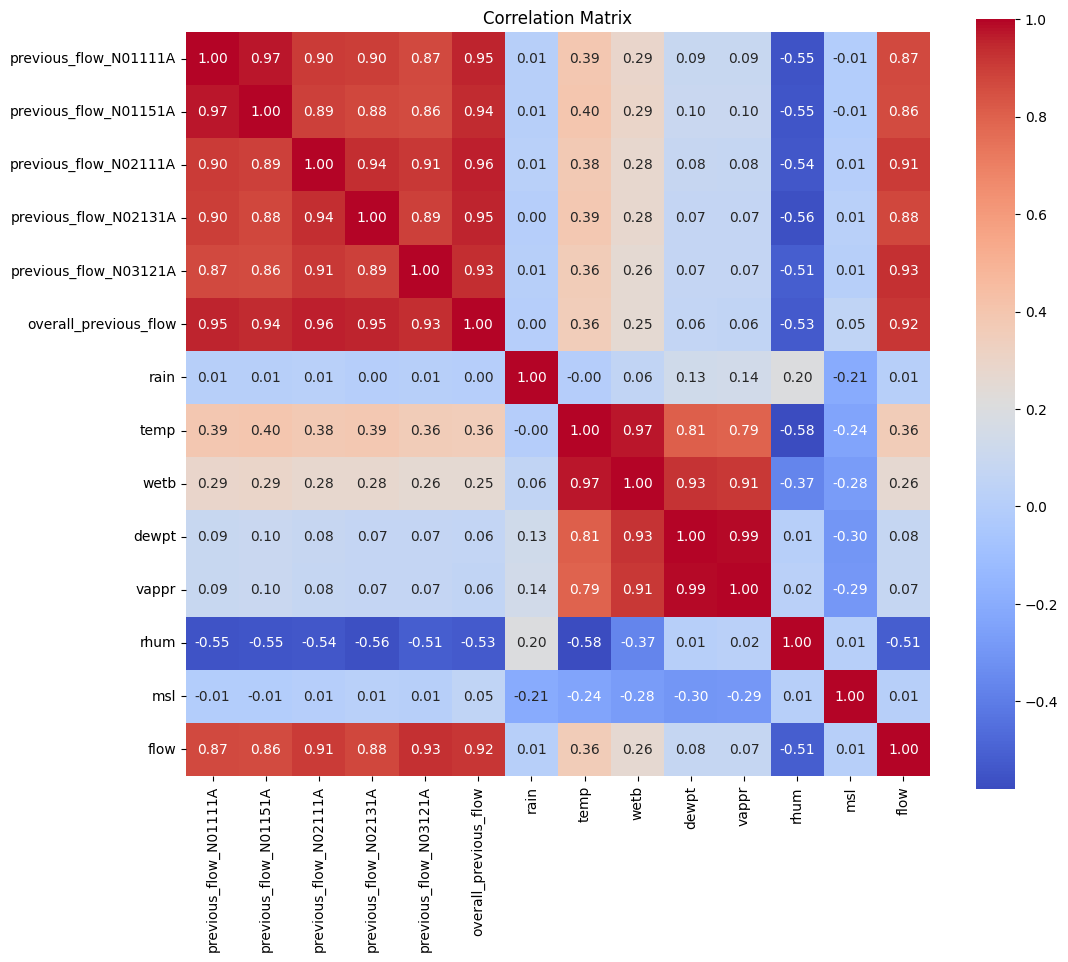

In [7]:
corr_features = num_features+ ['flow']
correlation_matrix = df[corr_features].corr()

# Set the size of the plot
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()



Observations
- The previous flows at other sites are highly correlated to each other
- Temperature is highly correlated with wet bulb and dew point temperature.
- we see that the current flow (our target variable)

### Train test split

In [8]:
X = df[num_features+cat_features]
y = df['flow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Model Selection
- From v2 notebook we saw Linear Regression, KNN and the multi-layer perceptron gave the best performance for predicting the traffic flow
- We will now focus on landing on the best final model to use via hyperparameter tuning

## 1. An interpretable model
- Interpretability of a machine learning model can often be hugely important and valuable for key stakeholders
- Deep learning and neural networks create models that can provide excellent performance, however the complexity of these models make them difficult to interpret, meaning we cannot understand why the network is predicting the way it is based on the input features
**Why is interpretability important?**
- One of the use cases of our traffic flow model could be to help make decisions on traffic management systems
- Having accurate predictions of traffic flow is definetly useful, but what is also useful is understanding why traffic is predicted to be higher at a certain time 
- This could perhaps help the council identify some root causes of high traffic flow and thus fix any problems at the root of the issue rather than responding to traffic flow in real time with our complex but accurate neural network model
- Don't get me wrong, having an accurate prediction model is still hugely useful, especially in a scenario like this where you are realistically always going to have periods of high traffic flow. However with the massive advances in machine learning it can become easy to dismiss simpler models if they are not providing sufficient predictive power. However issues like this highlight they are still hugely useful and actually display real benefits over powerful neural networks at times

### 1.1 Linear Regression
- we use one hot encoding and numerical feature scaling for data preprocessing

In [9]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Set the depth
])

Lets now evaluate the performance of linear regression using 5-fold cross validation on the train and test cets

In [10]:
def cross_validate_train_and_test(pipeline, cv, X, y):

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    train_maes = []
    test_maes = []

    train_r2s = []
    test_r2s = []

    for train_index, val_index in kf.split(X):
        X_cv_train, X_cv_val = X.iloc[train_index], X.iloc[val_index]  # Use iloc for DataFrame
        y_cv_train, y_cv_val = y.iloc[train_index], y.iloc[val_index]  # Consistent naming

        # Fit the model
        pipeline.fit(X_cv_train, y_cv_train)

        # Calculate train and test errors
        predictions_train = pipeline.predict(X_cv_train)
        predictions_val = pipeline.predict(X_cv_val)
        
        mae_train = mean_absolute_error(y_cv_train, predictions_train)
        mae_val = mean_absolute_error(y_cv_val, predictions_val)

        r2_train = r2_score(y_cv_train, predictions_train)
        r2_test = r2_score(y_cv_val, predictions_val)


        train_maes.append(mae_train)
        test_maes.append(mae_val)

        train_r2s.append(r2_train)
        test_r2s.append(r2_test)

    mean_mae_test = np.mean(test_maes)
    mean_mae_train = np.mean(train_maes)
    mean_r2_test = np.mean(test_r2s)
    mean_r2_train = np.mean(train_r2s)

    print('Mean MAE Test:', mean_mae_test)
    print('Mean MAE Train:', mean_mae_train)
    print('Mean R2 Test:', mean_r2_test)
    print('Mean R2 Train:', mean_r2_train)

    return mean_mae_test, mean_mae_train, mean_r2_test, mean_r2_train

In [11]:
cross_validate_train_and_test(pipeline_lr, 5, X, y)

Mean MAE Test: 37.94270009208678
Mean MAE Train: 37.712679211895605
Mean R2 Test: 0.9003499124221565
Mean R2 Train: 0.9016744045938072


(np.float64(37.94270009208678),
 np.float64(37.712679211895605),
 np.float64(0.9003499124221565),
 np.float64(0.9016744045938072))

#### Observations
- The key thing to notice here is the very close values between the train and test errors. This indicates the model is **underfitting** and error in the model is dominated by the **bias**
    - lets verify this via a bias-variance decomposition of the squared error

#### Bias-Variance Decompisition

In [12]:
def bias_variance_pipeline(pipeline, X, y):

        pipeline.fit(X_train, y_train)
        # Separate the preprocessing step from the pipeline
        preprocessor = pipeline.named_steps['preprocessor']

        # Transform the training and test data using the preprocessing step
        X_train_processed = preprocessor.transform(X_train)
        X_test_processed = preprocessor.transform(X_test)

        # Now pass the processed NumPy arrays to bias_variance_decomp
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
                pipeline.named_steps['regressor'],  # Use only the regressor step here
                X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
                X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)
                loss='mse',
                random_seed=123)

        print(f"Average Expected Loss: {avg_expected_loss}")
        print(f"Average Bias: {avg_bias}")
        print(f"Average Variance: {avg_var}")


In [13]:
bias_variance_pipeline(pipeline_lr, X_train, y_train)

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_13234/1476791940.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_13234/1476791940.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)


Average Expected Loss: 3118.7125136491895
Average Bias: 3097.3410143513734
Average Variance: 21.371499297816165


#### Observations
- as predicted, the majority of the expected loss is coming from the bias term as opposed to the variance 
- we could therefore look at more complex model
    - One we we could increase the complexity of the model is via polynomial features so let's try this

##### 2.2.1.1 Polynomial Regression

In [14]:
def create_poly_pipeline(degree):
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=degree))  # Standardize numerical features
                ]), num_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
            ]
            )

    # Create the pipeline
    pipeline_lr_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())  # Set the depth
    ])
    return pipeline_lr_poly

Let's experiment with a few values of "degree" that controls the exponent of the polynomial

In [15]:
mae_test = []
mae_train = []
degrees = [1, 2, 3, 4]#, 5]
for degree in degrees:
    print('Degree Polynomial: ', degree)
    mean_mae_test, mean_mae_train, _, _ = cross_validate_train_and_test(create_poly_pipeline(degree), 5, X, y)
    mae_test.append(mean_mae_test)
    mae_train.append(mean_mae_train)
    print('')


Degree Polynomial:  1
Mean MAE Test: 37.9426990663373
Mean MAE Train: 37.71267860714961
Mean R2 Test: 0.9003499141820044
Mean R2 Train: 0.9016744045942777

Degree Polynomial:  2
Mean MAE Test: 37.55186487150003
Mean MAE Train: 36.91170082432903
Mean R2 Test: 0.9038298267520257
Mean R2 Train: 0.907641178497882

Degree Polynomial:  3
Mean MAE Test: 38.46613917325145
Mean MAE Train: 35.1677003698331
Mean R2 Test: 0.8971715555120342
Mean R2 Train: 0.9175524800225379

Degree Polynomial:  4
Mean MAE Test: 59.566174547105604
Mean MAE Train: 29.609631724157936
Mean R2 Test: -0.7247594561234079
Mean R2 Train: 0.9427478555520705



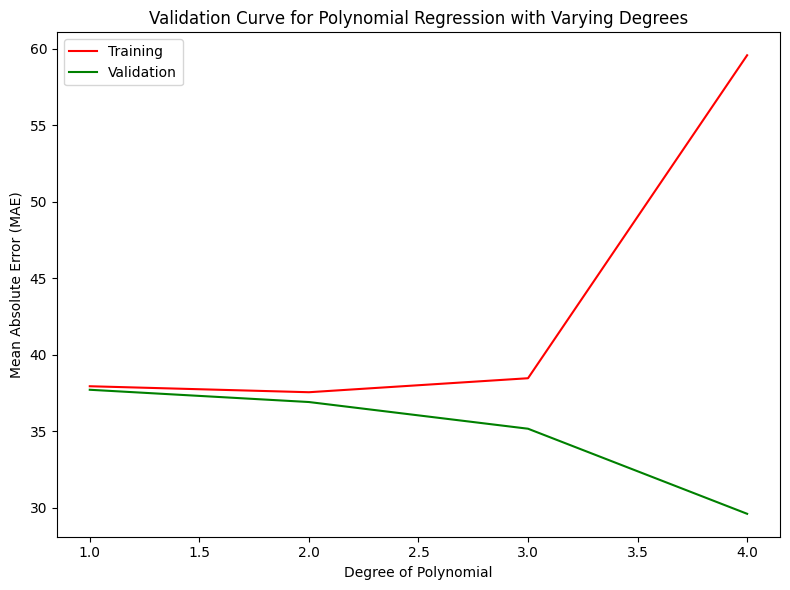

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(degrees, mae_test, label="Training", color="r")
plt.plot(degrees, mae_train, label="Validation", color="g")
plt.title("Validation Curve for Polynomial Regression with Varying Degrees")
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Absolute Error (MAE)")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### Observations
- We see that the training and test MAE actually start to diverge as we increase the degree of the polynomial. This shows we are fitting the training data better, but at the cost of decreased generalisation performance i.e. we are overfitting
- Simple linear regression is therefore the most optimal model to pick as it is the most interpretable and produces a good score on the test set

### 2.2.1 Support Vector Machine

In [17]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel="rbf")) 
])

In [18]:
cross_validate_train_and_test(pipeline_svm, 5, X, y)

Mean MAE Test: 46.45541587906972
Mean MAE Train: 46.110270329566255
Mean R2 Test: 0.8468381500506176
Mean R2 Train: 0.8480268116741237


(np.float64(46.45541587906972),
 np.float64(46.110270329566255),
 np.float64(0.8468381500506176),
 np.float64(0.8480268116741237))

## 2.3 Tree Models

### 2.3.1 Decision Tree
(No preprocessing steps needed for decision tree)

In [19]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())  # Set the depth
])

In [20]:
cross_validate_train_and_test(pipeline_dt, 5, X, y)

Mean MAE Test: 44.35753474218961
Mean MAE Train: 35.87800118880995
Mean R2 Test: 0.8477656996264635
Mean R2 Train: 0.8994298073767968


(np.float64(44.35753474218961),
 np.float64(35.87800118880995),
 np.float64(0.8477656996264635),
 np.float64(0.8994298073767968))

#### Observations
- The decision tree has decent performance but not better than linear regression
- We can see if the error is coming from the bias or variance term

In [21]:
bias_variance_pipeline(pipeline_dt, X, y)

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_13234/1476791940.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_processed, y_train.ravel(),  # Processed data (NumPy arrays)
/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_13234/1476791940.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_test_processed, y_test.ravel(),    # Processed data (NumPy arrays)


Average Expected Loss: 5330.026329617143
Average Bias: 4576.616174496772
Average Variance: 753.4101551203709


We see again the bias is much higher than the variance.
- Let's try more complex tree models

### 2.3.2 Random Forest & GBT

In [22]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))  
])

pipeline_gbt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=500))
])

In [23]:
print('Random Forest \n')
cross_validate_train_and_test(pipeline_rf, 5, X, y)
print('Gradient Boosted Tree')
cross_validate_train_and_test(pipeline_gbt, 5, X, y)


Random Forest 

Mean MAE Test: 43.449849609143506
Mean MAE Train: 36.00201941777067
Mean R2 Test: 0.8546632278110027
Mean R2 Train: 0.8992076074475236
Gradient Boosted Tree
Mean MAE Test: 45.60332284516675
Mean MAE Train: 44.04627337560443
Mean R2 Test: 0.8547483373267104
Mean R2 Train: 0.8652633805371078


(np.float64(45.60332284516675),
 np.float64(44.04627337560443),
 np.float64(0.8547483373267104),
 np.float64(0.8652633805371078))

- Results are still poor so lets not go with a tree model

## 2.4 Other Models

### 2.4.1 KNN

In [24]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=4, n_jobs=-1)) 
])

In [25]:
cross_validate_train_and_test(pipeline_knn, 5, X, y)


Mean MAE Test: 39.400053388853095
Mean MAE Train: 30.179622214293527
Mean R2 Test: 0.8886056942908802
Mean R2 Train: 0.9345571102858461


(np.float64(39.400053388853095),
 np.float64(30.179622214293527),
 np.float64(0.8886056942908802),
 np.float64(0.9345571102858461))

Observations
- KNN gives good performance but slightly overfits.

In [33]:

preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Replace missing values with 0
                ('scaler', StandardScaler())  # Standardize numerical features
            ]), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_nn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(max_iter=100, solver='lbfgs', alpha=0.001)) 
])

In [34]:
cross_validate_train_and_test(pipeline_nn, 5, X, y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network

Mean MAE Test: 36.021747942857374
Mean MAE Train: 34.434398420878324
Mean R2 Test: 0.9096418367318847
Mean R2 Train: 0.917697356728908


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(np.float64(36.021747942857374),
 np.float64(34.434398420878324),
 np.float64(0.9096418367318847),
 np.float64(0.917697356728908))

- Multilayer Perceptron gives similar performance to linear regression 

## Model Selection - Conclusions
- We have tried most of the most common regressor models
- Performance is quite similar across the models and in this scenario we should pick the model that is simplest and computationally inexpensive.
- The first model linear regression gives one of the best performances while retaining that key aspect of interpetability, so we will stick with that

# Model Analysis
We have chosen linear regression as our machine learning model so lets look into it a bit more

In [35]:
df['month'].value_counts(
    
)

month
1    2400
5    2400
3    2397
4    2304
6    2304
2    2112
Name: count, dtype: int64

In [28]:
lr_model = pipeline_lr[1]


In [29]:
pipeline_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['previous_flow_N01111A',
                                                   'previous_flow_N01151A',
                                                   'previous_flow_N02111A',
                                                   'previous_flow_N02131A',
                                                   'previous_flow_N03121A',
                                                   'overall_previous_flow',
                                                   'rain', 'temp', 'wetb',
                                                   'dewpt', 'vappr', 'rhum',
                                                   'msl']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['day', 'time_(half_hour)',
                                                   'month'])])),
                ('regressor', LinearRegression())])

In [30]:
encoded_feature_names = column_transformer.transformers_[0][1].get_feature_names_out(input_features=['categorical_feature_column'])


NameError: name 'column_transformer' is not defined

In [ ]:
num_feature_names = num_features

# Get feature names from the categorical features (after OneHotEncoding)
cat_feature_names = pipeline_lr.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(input_features=cat_features)

# Combine the feature names
all_feature_names = num_feature_names + list(cat_feature_names)

# Get the coefficients (feature importance) from the linear regression model
coefficients = pipeline_lr.named_steps['regressor'].coef_

# Create a DataFrame to display feature names and their corresponding importance
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': coefficients})

# Sort by absolute importance
importance_df['Abs_Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)
importance_df

,Feature,Importance,Abs_Importance
4,previous_flow_N03121A,87.545255,87.545255
33,time_(half_hour)_06:30,58.913419,58.913419
49,time_(half_hour)_14:30,57.922387,57.922387
2,previous_flow_N02111A,54.119212,54.119212
52,time_(half_hour)_16:00,52.946440,52.946440
...,...,...,...
6,rain,-0.398359,0.398359
14,day_MO,0.246013,0.246013
12,msl,-0.232063,0.232063
57,time_(half_hour)_18:30,0.151157,0.151157


/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12340/2299553149.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Importance', y='Feature', data=top_20_features, palette='viridis')  # You can change the palette as needed


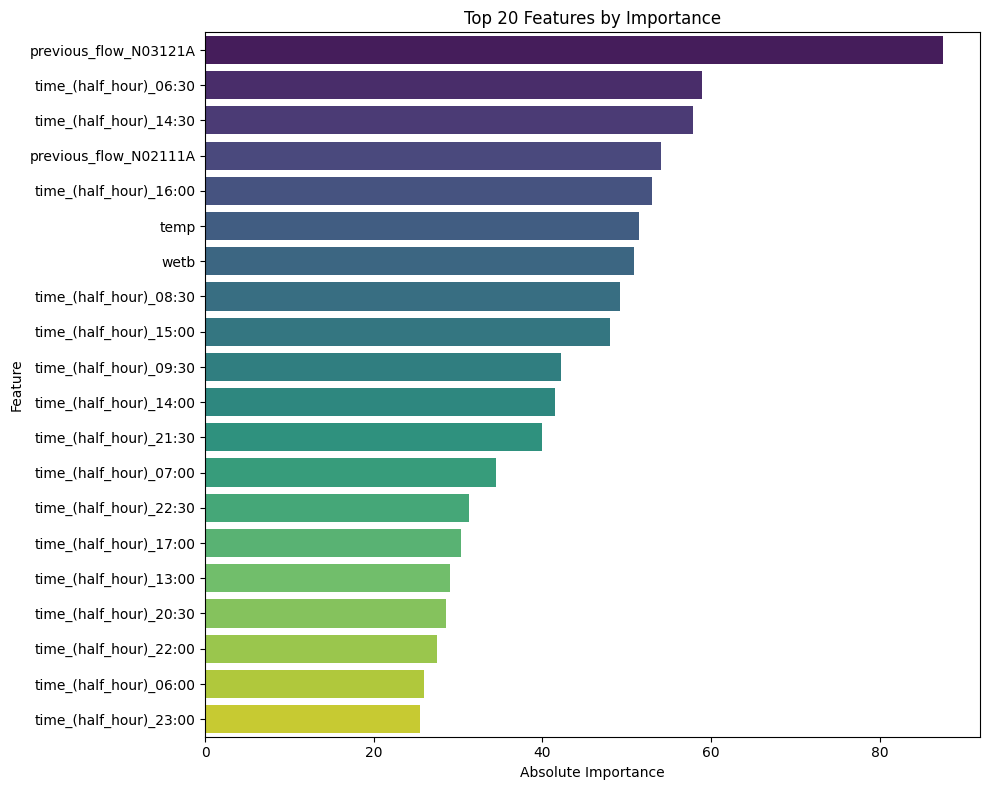

In [ ]:
top_20_features = importance_df.sort_values(by='Abs_Importance', ascending=False).head(20)

# Plotting the sideways bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Abs_Importance', y='Feature', data=top_20_features, palette='viridis')  # You can change the palette as needed
plt.title('Top 20 Features by Importance')
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_12340/1638503138.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Importance', y='Feature', data=bot_20_features, palette='viridis')  # You can change the palette as needed


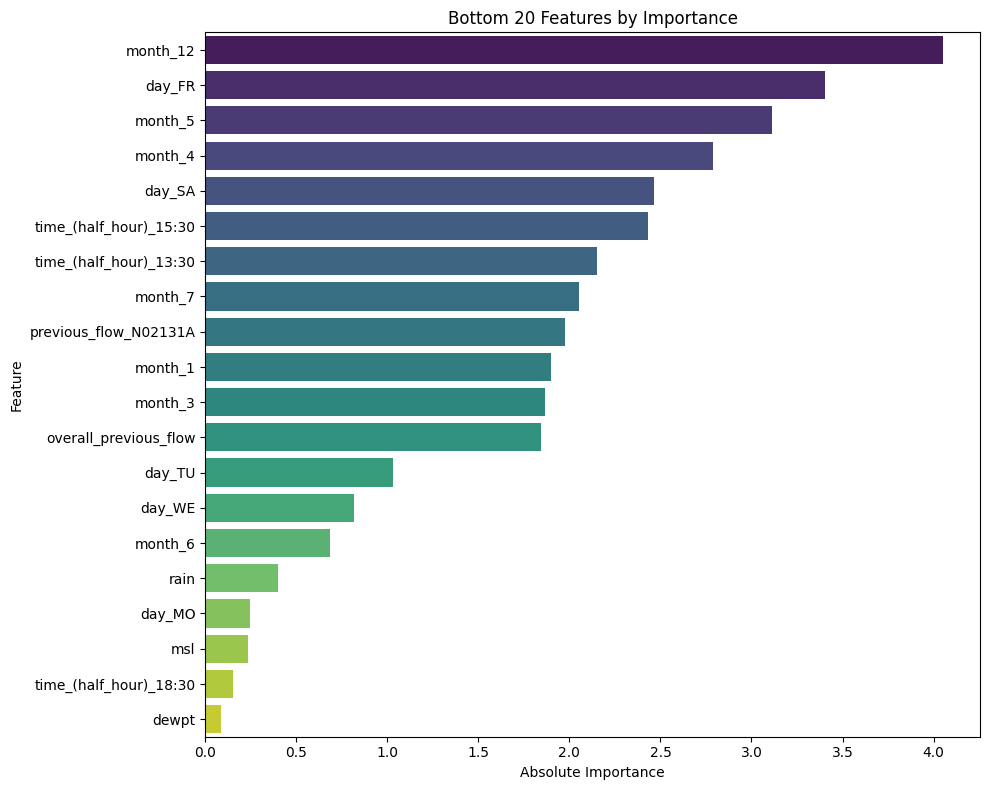

In [ ]:
bot_20_features = importance_df.sort_values(by='Abs_Importance', ascending=False).tail(20)

# Plotting the sideways bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Abs_Importance', y='Feature', data=bot_20_features, palette='viridis')  # You can change the palette as needed
plt.title('Bottom 20 Features by Importance')
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
df[['month']].value_counts()

month
1        2400
5        2400
3        2397
4        2304
6        2304
2        2112
7         576
8         576
9         576
10        576
11        576
12        576
Name: count, dtype: int64